In [2]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("pgf")
#import tikzplotlib

In [3]:

print('mpl: {}'.format(mpl.__version__))

mpl: 3.9.2


In [4]:
def parse_results(filename:str) -> Tuple[pd.DataFrame, float, int, int]:
    """
    Parse a .txt file and return the results as a DataFrame.

    Parameters:
        filename (str): The name of the input file.

    Returns:
        Tuple[pd.DataFrame, float, int]: DataFrame of results, number of queries, number of hashes, and number of filter bits.
    """
    with open(filename) as f:
        lines = f.readlines()[2:]
    ignore_from_idx = lines.index("PROPERTIES:\n")
    results = lines[:ignore_from_idx-1] # there is an empty line preceding the ignore_from_idx
    results_clean = [r.strip("\n") for r in results]
    results_df = pd.DataFrame(sub.split("\t") for sub in results_clean[1:])
    results_df.columns = results_clean[0].split("\t")
    for col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col])

    # get the config values
    lines = lines[ignore_from_idx+1:] 
    num_queries = None
    lg_expected_cardinality = None
    for line in lines:
        if "lgNumQueries" in line:
            num_queries = 2.**int(line.split("=")[-1])
        if "lgExpectedCardinality" in line:
            lg_expected_cardinality = int(line.split("=")[-1])
    results_df["trialFPR"] = results_df["NumFalsePositives"] / num_queries
    return results_df, int(num_queries), results_df["NumHashes"].values[0], results_df["NumFilterBits"].values[0], lg_expected_cardinality

In [5]:
bf_results, bf_num_queries, h, m, lgn  = parse_results("../results/BloomFilterFalsePositiveVsCardinalityProfile20240829_011618PST.txt")
print("Number of Queries: ", bf_num_queries)
print("Number of Hashes:  ", h)
print("Number of Filter Bits:", m)
print("Configured Cardinality: ", 1<<lgn)

Number of Queries:  1024
Number of Hashes:   6
Number of Filter Bits: 15127754
Configured Cardinality:  2097152


In [6]:
bf_results.head()

,NumInput,NumFilterBits,NumHashes,NumFalsePositives,NumBitsSet,trialFPR
0,524288,15127754,6,0,2840554,0.0
1,549084,15127754,6,0,2960671,0.0
2,575052,15127754,6,0,3085561,0.0
3,602249,15127754,6,0,3214716,0.0
4,630732,15127754,6,0,3348949,0.0


In [7]:
bf_results[bf_results["NumInput"] == 524288]

,NumInput,NumFilterBits,NumHashes,NumFalsePositives,NumBitsSet,trialFPR
0,524288,15127754,6,0,2840554,0.000000
73,524288,15127754,6,1,2840513,0.000977
146,524288,15127754,6,0,2839844,0.000000
219,524288,15127754,6,0,2839739,0.000000
292,524288,15127754,6,0,2840000,0.000000
...,...,...,...,...,...,...
8979,524288,15127754,6,0,2840195,0.000000
9052,524288,15127754,6,0,2840823,0.000000
9125,524288,15127754,6,0,2840210,0.000000
9198,524288,15127754,6,1,2840393,0.000977


In [8]:
def get_mean_by_group(results_df:pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the mean values of specific columns grouped by 'NumInput'.

    This function groups the input DataFrame by the 'NumInput' column and calculates
    the mean of 'NumFalsePositives', 'trialFPR', and 'NumBitsSet' for each group.
    It returns a new DataFrame with these mean values.

    Parameters:
        results_df (pd.DataFrame): The input DataFrame containing the columns 'NumInput',
                                'NumFalsePositives', 'trialFPR', and 'NumBitsSet'.

    Returns:
        pd.DataFrame: A DataFrame with columns 'NumInput', 'MeanNumFPs', 'MeanTrialFPR',
                    and 'MeanNumBitsSet', where each row corresponds to a unique 'NumInput'
    """
    means = []
    for gg in results_df.groupby("NumInput"):
        means.append([int(gg[0]), gg[1]["NumFalsePositives"].mean(), gg[1]["trialFPR"].mean(), gg[1]["NumBitsSet"].mean()])
    mean_df = pd.DataFrame(np.array(means), columns=["NumInput", "MeanNumFPs", "MeanTrialFPR", "MeanNumBitsSet"])
    mean_df["NumInput"] = pd.to_numeric(mean_df["NumInput"]).astype(int)
    return mean_df

def bloom_filter_fpr_bound(cardinality_arr:np.array, num_hashes:int, num_filter_bits:int) -> np.array:
    """
    Calculate the false positive rate (FPR) bound for a Bloom filter.

    Parameters:
        cardinality_arr (np.array): Array of integers representing the cardinality.
        num_hashes (int): Number of hash functions.
        num_filter_bits (int): Number of bits in the Bloom filter.

    Returns:
        np.array: Array of FPR bounds.

    Raises:
        AssertionError: If cardinality_arr is not a numpy array of integers.
    """
    assert isinstance(cardinality_arr, np.ndarray), "cardinality_arr must be a numpy array"
    assert issubclass(cardinality_arr.dtype.type, np.integer), "cardinality_arr must contain integers"
    #probs = (1.-np.exp( -(num_hashes * cardinality_arr)/num_filter_bits))**num_hashes
    #print(probs)
    return (1.-np.exp( -(num_hashes * cardinality_arr)/num_filter_bits))**num_hashes



In [9]:
mean_num_entries_fpr = get_mean_by_group(bf_results)
bloom_fpr_theory = bloom_filter_fpr_bound(mean_num_entries_fpr["NumInput"].values, h, m)

In [10]:
type(mean_num_entries_fpr["NumInput"])

pandas.core.series.Series

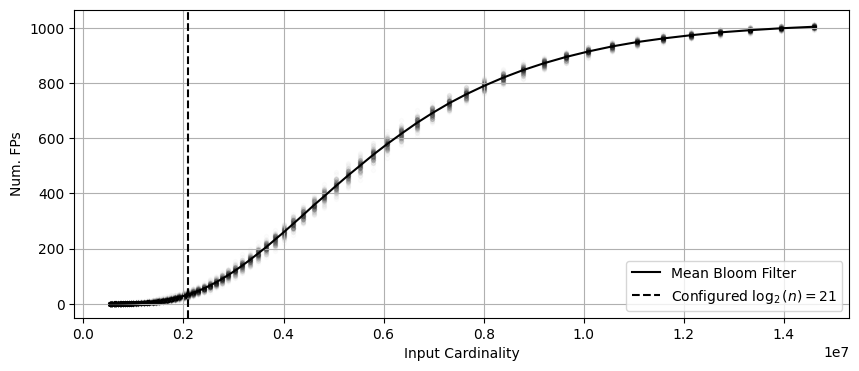

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["NumFalsePositives"], marker=".", color="black", alpha=0.01)
ax.plot(mean_num_entries_fpr["NumInput"].values, mean_num_entries_fpr["MeanNumFPs"].values, color="black", label="Mean Bloom Filter")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Num. FPs")
ax.legend()
ax.grid()
plt.show()

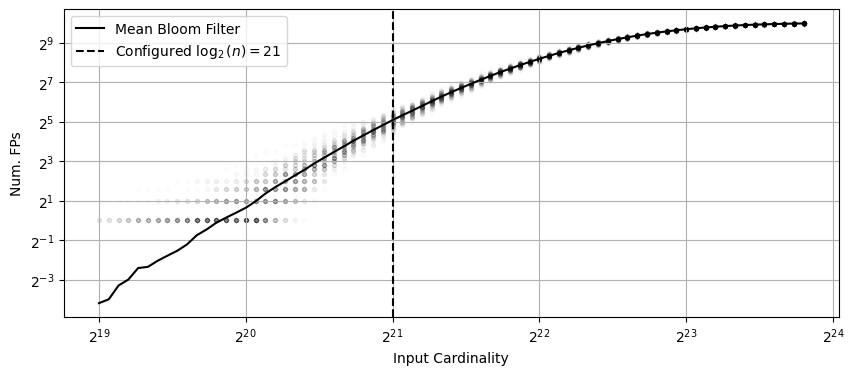

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["NumFalsePositives"], marker=".", color="black", alpha=0.01)
ax.plot(mean_num_entries_fpr["NumInput"].values, mean_num_entries_fpr["MeanNumFPs"].values, color="black", label="Mean Bloom Filter")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Num. FPs")
ax.legend()
ax.grid()

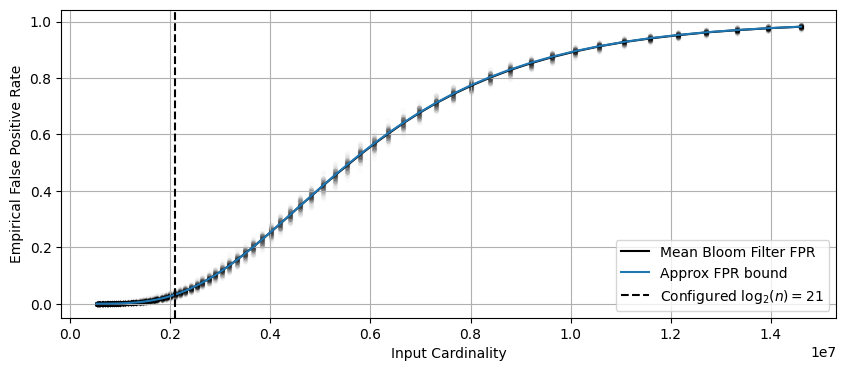

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["trialFPR"], marker=".", color="black", alpha=0.01)
ax.plot(mean_num_entries_fpr["NumInput"].values, mean_num_entries_fpr["MeanTrialFPR"].values, color="black", label="Mean Bloom Filter FPR")
ax.plot(mean_num_entries_fpr["NumInput"].values, bloom_fpr_theory, label="Approx FPR bound")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Empirical False Positive Rate")
ax.legend()
ax.grid()

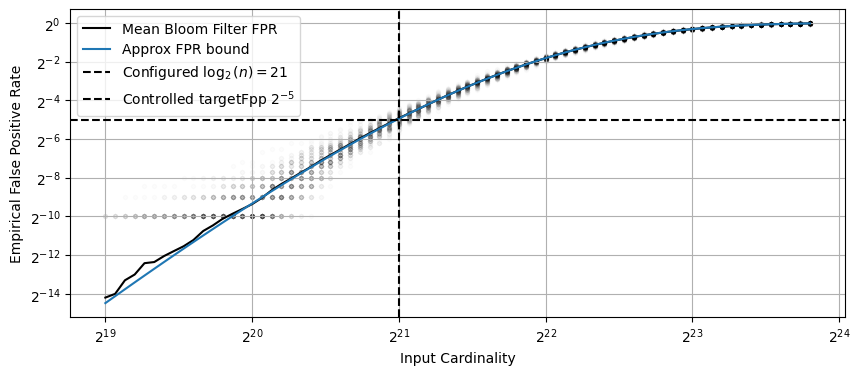

In [110]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["trialFPR"], marker=".", color="black", alpha=0.01)
ax.plot(mean_num_entries_fpr["NumInput"], mean_num_entries_fpr["MeanTrialFPR"], color="black", label="Mean Bloom Filter FPR")
ax.plot(mean_num_entries_fpr["NumInput"], bloom_fpr_theory, label="Approx FPR bound")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.axhline(y=2.**(-5.), color='black', linestyle='--', label=r'Controlled targetFpp $2^{-5}$')
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Empirical False Positive Rate")
ax.legend()
ax.grid()
fig.savefig("bloom_filter_fpr_vs_cardinality.png")

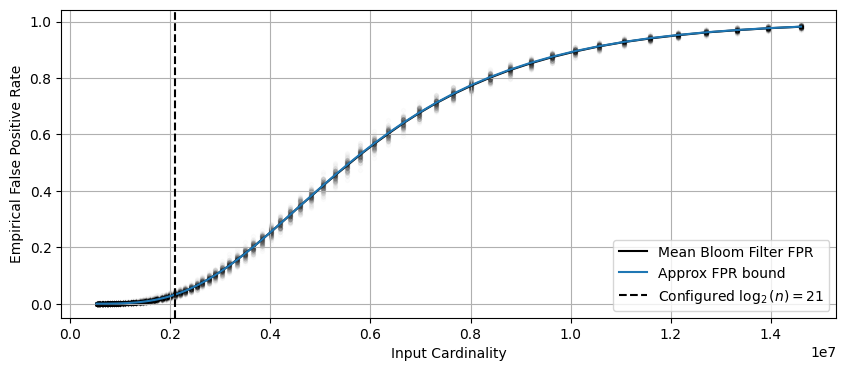

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(bf_results["NumInput"].values, bf_results["trialFPR"].values, marker=".", color="black", alpha=0.01)
ax.plot(mean_num_entries_fpr["NumInput"].values, mean_num_entries_fpr["MeanTrialFPR"].values, color="black", label="Mean Bloom Filter FPR")
ax.plot(mean_num_entries_fpr["NumInput"].values, bloom_fpr_theory, label="Approx FPR bound")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Empirical False Positive Rate")
ax.legend()
ax.grid()
#tikzplotlib.clean_figure()
#tikzplotlib.save("test.tex")

In [14]:
def compute_empirical_fpr_error_stats(df: pd.DataFrame) -> Tuple[pd.DataFrame, np.array]:
    """
    Compute empirical FPR error statistics.

    Parameters:
    df (pd.DataFrame): DataFrame containing the input data.

    Returns:
    Tuple[pd.DataFrame, np.array]: DataFrame with mean and std of empirical FPR errors,
                                   and an array of all empirical FPR errors.
    """
    bloom_fpr_theory = bloom_filter_fpr_bound(df["NumInput"].values, h, m)
    empirical_fpr_errors = []
    empirical_fpr_errors_mean = []
    empirical_fpr_errors_std = []
    empirical_fpr_errors_5_quantile = []
    empirical_fpr_errors_95_quantile = []
    
    for i, g in enumerate(df.groupby("NumInput")):
        group_prob_errors = g[1]["trialFPR"] - bloom_fpr_theory[i]
        empirical_fpr_errors_mean.append(group_prob_errors.mean())
        empirical_fpr_errors_std.append(group_prob_errors.std())
        empirical_fpr_errors_5_quantile.append(np.percentile(group_prob_errors, 5))
        empirical_fpr_errors_95_quantile.append(np.percentile(group_prob_errors, 95))
        empirical_fpr_errors.extend(group_prob_errors)
    
    empirical_fpr_errors_arr = np.array(empirical_fpr_errors)
    empirical_fpr_errors_mean_arr = np.array(empirical_fpr_errors_mean)
    empirical_fpr_errors_std_arr = np.array(empirical_fpr_errors_std)
    empirical_fpr_errors_5_quantile_arr = np.array(empirical_fpr_errors_5_quantile)
    empirical_fpr_errors_95_quantile_arr = np.array(empirical_fpr_errors_95_quantile)
    
    result_df = pd.DataFrame({
        "NumInput": df["NumInput"].unique(),
        "MeanEmpiricalFPRErrors": empirical_fpr_errors_mean_arr,
        "StdEmpiricalFPRErrors": empirical_fpr_errors_std_arr,
        "5%QuantileEmpiricalFPRErrors": empirical_fpr_errors_5_quantile_arr,
        "95%QuantileEmpiricalFPRErrors": empirical_fpr_errors_95_quantile_arr
    })
    
    return result_df, empirical_fpr_errors_arr

# Example usage
fpr_dist_df, fpr_errors = compute_empirical_fpr_error_stats(bf_results)

In [15]:
fpr_dist_df

,NumInput,MeanEmpiricalFPRErrors,StdEmpiricalFPRErrors,5%QuantileEmpiricalFPRErrors,95%QuantileEmpiricalFPRErrors
0,524288,0.000010,0.000223,-0.000044,0.000591
1,549084,0.000005,0.000237,-0.000056,0.000920
2,575052,0.000027,0.000321,-0.000072,0.000905
3,602249,0.000030,0.000347,-0.000092,0.000885
4,630732,0.000066,0.000454,-0.000118,0.000859
...,...,...,...,...,...
68,12140574,-0.000941,0.005719,-0.009959,0.008254
69,12714752,-0.000534,0.005469,-0.010720,0.008470
70,13316085,-0.000667,0.005363,-0.009572,0.008641
71,13945858,-0.000393,0.004595,-0.006741,0.007907


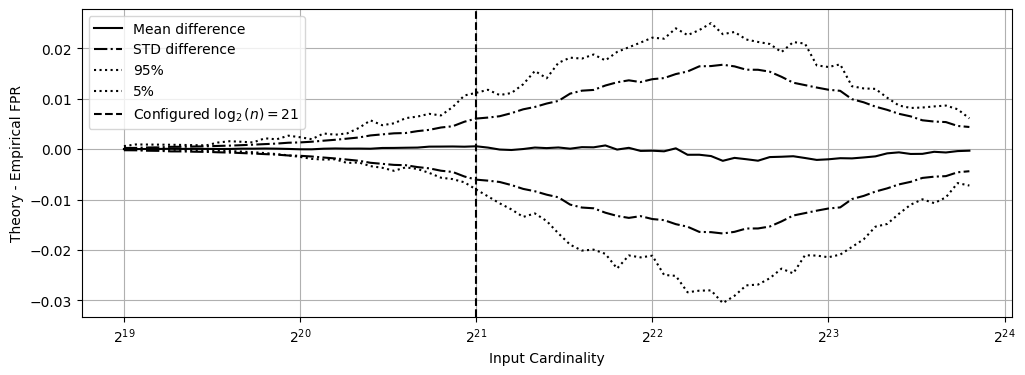

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
#ax.scatter(bf_results["NumInput"], fpr_errors, marker=".", color="black", alpha=0.1)
ax.plot(mean_num_entries_fpr["NumInput"], fpr_dist_df["MeanEmpiricalFPRErrors"], color="black", label="Mean difference")
ax.plot(mean_num_entries_fpr["NumInput"], fpr_dist_df["StdEmpiricalFPRErrors"], color="black", label="STD difference", linestyle="-.")
ax.plot(mean_num_entries_fpr["NumInput"], -1.*fpr_dist_df["StdEmpiricalFPRErrors"], color="black", linestyle="-.")  
ax.plot(mean_num_entries_fpr["NumInput"], fpr_dist_df["95%QuantileEmpiricalFPRErrors"], color="black", label="95%", linestyle=":")
ax.plot(mean_num_entries_fpr["NumInput"], fpr_dist_df["5%QuantileEmpiricalFPRErrors"], color="black", label="5%", linestyle=":")
ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.set_xscale("log", base=2)
ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Theory - Empirical FPR")
ax.legend()
ax.grid()
fig.savefig("bloom_filter_fpr_error_bound_vs_cardinality.png")

## 2. Testing with different configurations.

In [35]:
bf_under_results, bf_under_num_queries, h_under, m_under, lgn_under  = parse_results("../results/BloomFilterFalsePositiveVsCardinalityProfile20240903_053439PST.txt")
print("Number of Queries: ", bf_under_num_queries)
print("Number of Hashes:  ", h_under)
print("Number of Filter Bits:", m_under)
print("Configured Cardinality: ", 1<<lgn_under)
print("\n", "-"*40, "\n")
bf_over_results, bf_over_num_queries, h_over, m_over, lgn_over  = parse_results("../results/BloomFilterFalsePositiveVsCardinalityProfile20240903_054825PST.txt")
print("Number of Queries: ", bf_over_num_queries)
print("Number of Hashes:  ", h_over)
print("Number of Filter Bits:", m_over)
print("Configured Cardinality: ", 1<<lgn_over)

Number of Queries:  1024
Number of Hashes:   6
Number of Filter Bits: 7563877
Configured Cardinality:  1048576

 ---------------------------------------- 

Number of Queries:  1024
Number of Hashes:   6
Number of Filter Bits: 30255508
Configured Cardinality:  4194304


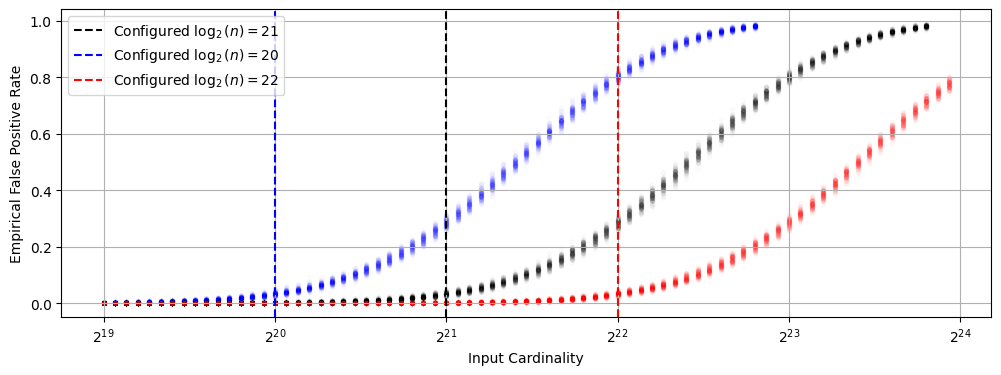

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(bf_results["NumInput"], bf_results["trialFPR"], marker=".", color="black", alpha=0.01)
ax.scatter(bf_under_results["NumInput"], bf_under_results["trialFPR"], marker=".", color="blue", alpha=0.01)
ax.scatter(bf_over_results["NumInput"], bf_over_results["trialFPR"], marker=".", color="red", alpha=0.01)


ax.axvline(x=1<<lgn, color='black', linestyle='--', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.axvline(x=1<<lgn_under, color='blue', linestyle='--', label=r'Configured $\log_2(n) = {lgn_under}$'.format(lgn_under=lgn_under))
ax.axvline(x=1<<lgn_over, color='red', linestyle='--', label=r'Configured $\log_2(n) = {lgn_over}$'.format(lgn_over=lgn_over))


ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Empirical False Positive Rate")
ax.set_xscale("log", base=2)
ax.legend()
ax.grid()
fig.savefig("bloom_filter_fpr_vs_cardinality_vary_config_n.png")

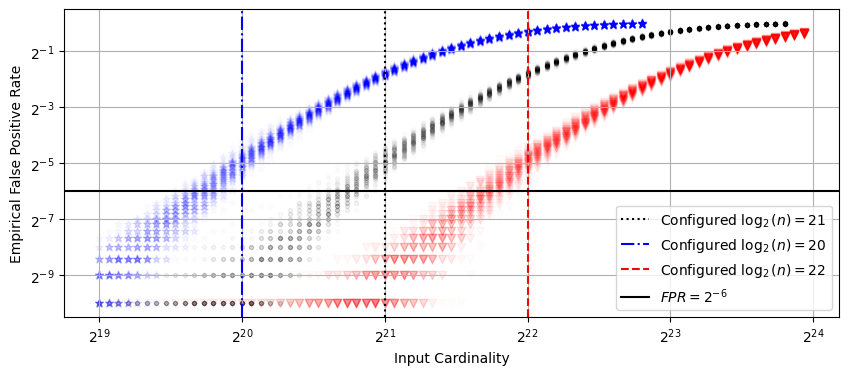

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["trialFPR"], marker=".", color="black", alpha=0.01)
ax.scatter(bf_under_results["NumInput"], bf_under_results["trialFPR"], marker="*", color="blue", alpha=0.01)
ax.scatter(bf_over_results["NumInput"], bf_over_results["trialFPR"], marker="v", color="red", alpha=0.01)


ax.axvline(x=1<<lgn, color='black', linestyle=':', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.axvline(x=1<<lgn_under, color='blue', linestyle='-.', label=r'Configured $\log_2(n) = {lgn_under}$'.format(lgn_under=lgn_under))
ax.axvline(x=1<<lgn_over, color='red', linestyle='--', label=r'Configured $\log_2(n) = {lgn_over}$'.format(lgn_over=lgn_over))
ax.axhline(2.**(-h), color='black', linestyle='-', label=fr'$FPR = 2^{{{-h}}}$')


ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Empirical False Positive Rate")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.legend()
ax.grid()
fig.savefig("bloom_filter_fpr_vs_cardinality_vary_config_n_log.png")

## 3. Fraction of bits set

In [39]:
for df in [bf_results, bf_under_results, bf_over_results]:
    df["fracBitsSet"] = df["NumBitsSet"] / df["NumFilterBits"]

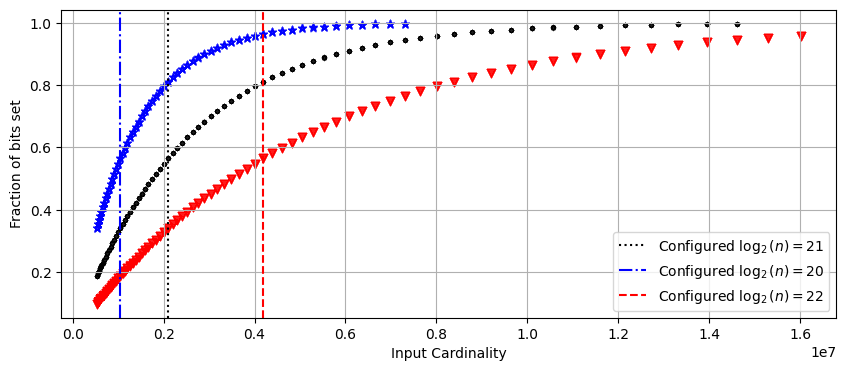

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["NumInput"], bf_results["fracBitsSet"], marker=".", color="black", alpha=0.01)
ax.scatter(bf_under_results["NumInput"], bf_under_results["fracBitsSet"], marker="*", color="blue", alpha=0.01)
ax.scatter(bf_over_results["NumInput"], bf_over_results["fracBitsSet"], marker="v", color="red", alpha=0.01)


ax.axvline(x=1<<lgn, color='black', linestyle=':', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.axvline(x=1<<lgn_under, color='blue', linestyle='-.', label=r'Configured $\log_2(n) = {lgn_under}$'.format(lgn_under=lgn_under))
ax.axvline(x=1<<lgn_over, color='red', linestyle='--', label=r'Configured $\log_2(n) = {lgn_over}$'.format(lgn_over=lgn_over))


ax.set_xlabel("Input Cardinality")
ax.set_ylabel("Fraction of bits set")
# ax.set_xscale("log", base=2)
# ax.set_yscale("log", base=2)
ax.legend()
ax.grid()

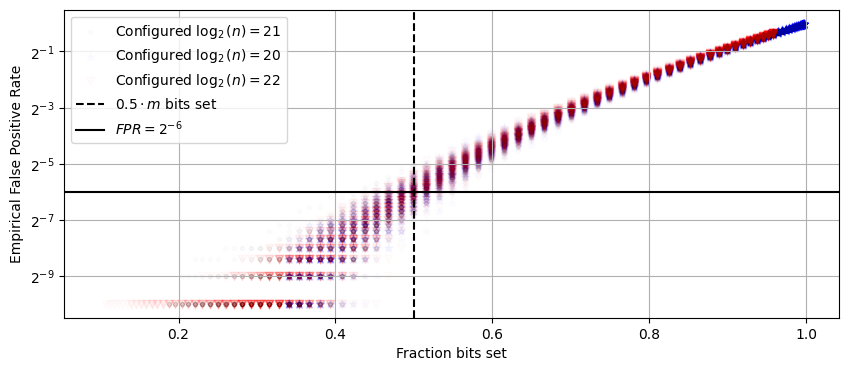

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(bf_results["fracBitsSet"], bf_results["trialFPR"], marker=".", color="black", alpha=0.01, label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
ax.scatter(bf_under_results["fracBitsSet"], bf_under_results["trialFPR"], marker="*", color="blue", alpha=0.01, label=r'Configured $\log_2(n) = {lgn_under}$'.format(lgn_under=lgn_under))
ax.scatter(bf_over_results["fracBitsSet"], bf_over_results["trialFPR"], marker="v", color="red", alpha=0.01, label=r'Configured $\log_2(n) = {lgn_over}$'.format(lgn_over=lgn_over))


# ax.axvline(x=1<<lgn, color='black', linestyle=':', label=r'Configured $\log_2(n) = {lgn}$'.format(lgn=lgn))
# ax.axvline(x=1<<lgn_under, color='blue', linestyle='-.', label=r'Configured $\log_2(n) = {lgn_under}$'.format(lgn_under=lgn_under))
# ax.axvline(x=1<<lgn_over, color='red', linestyle='--', label=r'Configured $\log_2(n) = {lgn_over}$'.format(lgn_over=lgn_over))
ax.axvline(x=0.5, color='black', linestyle='--', label=r"$0.5 \cdot m$ bits set")
ax.axhline(2.**(-h), color='black', linestyle='-', label=fr'$FPR = 2^{{{-h}}}$')

ax.set_xlabel("Fraction bits set")
ax.set_ylabel("Empirical False Positive Rate")
#ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.legend()
ax.grid()
fig.savefig("bloom_filter_fpr_bits_set.png")